In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os, gc, datetime
from time import time

import numpy as np
import pandas as pd
import datatable as dtable
import seaborn as sns
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
from sklearn.metrics import roc_auc_score, accuracy_score

from IPython import display
from matplotlib import pyplot as plt
from tqdm import tqdm

import tensorflow as tf
import tensorflow_addons as tfa
tf.random.set_seed(42)
import tensorflow.keras.backend as K
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

In [ ]:
train = dtable.fread('/kaggle/input/jane-street-market-prediction/train.csv').to_pandas()

In [ ]:
features = [c for c in train.columns if 'feature' in c]
f_mean = train.loc[:, features[1:]].mean()
train = train.query('weight > 0').reset_index(drop = True)
train = train.query('date > 85').reset_index(drop = True)
train.loc[:, features[1:]] = train.loc[:, features[1:]].fillna(f_mean)
train.loc[:, 'action'] = (train.loc[:, 'resp'] > 0).astype('int')

resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']

f_mean = f_mean.values
np.save('f_mean.npy', f_mean)

X = train[features].values
y = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T

In [ ]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]


In [ ]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self._supports_tf_logs = True

    def on_epoch_end(self, epoch, logs=None):
        if logs is None or "learning_rate" in logs:
            return
        logs["learning_rate"] = self.model.optimizer.lr

        
def get_callbacks(name, fold):
    return [
        ReduceLROnPlateau(monitor = 'val_AUC', factor = 0.5, patience = 5, verbose = 0, min_delta = 1e-4, mode = 'max'),
        ModelCheckpoint(f'JSModel_{fold}.hdf5' , monitor = 'val_AUC', verbose = 0, save_best_only = True, 
                        save_weights_only = True, mode = 'max'),
        EarlyStopping(monitor = 'val_AUC', min_delta = 1e-4, patience = 15, mode = 'max', 
                      baseline = None, restore_best_weights = True, verbose = 0),
        LearningRateLogger(),
        # tf.keras.callbacks.TensorBoard(logdir/f"{name}_{fold}"),
    ]

In [ ]:
def utility_score_bincount(date, weight, resp, action):
    count_i = len(np.unique(date))
    Pi = np.bincount(date, weight * resp * action)
    t = np.sum(Pi) / np.sqrt(np.sum(Pi ** 2)) * np.sqrt(250 / count_i)
    u = np.clip(t, 0, 6) * np.sum(Pi)
    return u

## use tags cluster info from Ignacio's https://www.kaggle.com/ignacioalorre/clustering-features-based-on-correlation-and-tags

In [ ]:
c_1 = ["feature_0", "feature_1","feature_3","feature_5","feature_7","feature_9","feature_11","feature_13","feature_15","feature_17","feature_19","feature_21","feature_23","feature_25","feature_27","feature_29","feature_31","feature_33","feature_35","feature_37","feature_39","feature_41","feature_42","feature_43","feature_44","feature_45","feature_46","feature_47","feature_48","feature_49","feature_50","feature_51","feature_52","feature_53","feature_54","feature_55","feature_56","feature_57","feature_58","feature_59","feature_60","feature_61","feature_62","feature_63","feature_64","feature_65","feature_66","feature_67","feature_68","feature_69","feature_70","feature_71","feature_120","feature_121","feature_122","feature_123","feature_124","feature_125","feature_126","feature_127","feature_128","feature_129"]
c_2 = ["feature_0", "feature_78","feature_79","feature_80","feature_81","feature_82","feature_83","feature_90","feature_91","feature_92","feature_93","feature_94","feature_95","feature_102","feature_103","feature_104","feature_105","feature_106","feature_107","feature_114","feature_115","feature_116","feature_117","feature_118","feature_119"]
c_3 = ["feature_0", "feature_72","feature_73","feature_74","feature_75","feature_76","feature_77","feature_84","feature_85","feature_86","feature_87","feature_88","feature_89","feature_96","feature_97","feature_98","feature_99","feature_100","feature_101","feature_108","feature_109","feature_110","feature_111","feature_112","feature_113"]
c_4 = ["feature_0", "feature_2","feature_4","feature_6","feature_8","feature_10","feature_12","feature_14","feature_16","feature_18","feature_20","feature_22","feature_24","feature_26","feature_28","feature_30","feature_32","feature_34","feature_36","feature_38","feature_40"]

In [ ]:
c_1_ = np.array([int(x.split("_")[-1]) for x in c_1])
c_2_ = np.array([int(x.split("_")[-1]) for x in c_2])
c_3_ = np.array([int(x.split("_")[-1]) for x in c_3])
c_4_ = np.array([int(x.split("_")[-1]) for x in c_4])

In [ ]:
f_shape = [len(c_1), len(c_2), len(c_3), len(c_4)]
f_shape

In [ ]:
from tensorflow.keras.utils import plot_model

def model_1(inp):
    x = tf.keras.layers.LayerNormalization()(inp)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(64)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    out = tf.keras.layers.Dropout(0.1)(x)
    return out
    

def model_2(inp):
    x = tf.keras.layers.LayerNormalization()(inp)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    out = tf.keras.layers.Dropout(0.1)(x)
    return out

def model_3(inp):
    x = tf.keras.layers.LayerNormalization()(inp)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    out = tf.keras.layers.Dropout(0.1)(x)
    return out

def model_4(inp):
    x = tf.keras.layers.LayerNormalization()(inp)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    out = tf.keras.layers.Dropout(0.1)(x)
    return out


def create_mlp(f_shape, num_labels, hidden_units, dropout_rates, label_smoothing, learning_rate):
    
    inp1 = tf.keras.layers.Input(shape = (f_shape[0], ))
    inp2 = tf.keras.layers.Input(shape = (f_shape[1], ))
    inp3 = tf.keras.layers.Input(shape = (f_shape[2], ))
    inp4 = tf.keras.layers.Input(shape = (f_shape[3], ))
    
    mlp1 = model_1(inp1)
    mlp2 = model_2(inp2)
    mlp3 = model_3(inp3)
    mlp4 = model_4(inp4)
    
    combined = tf.keras.layers.Concatenate()([mlp1, mlp2, mlp3, mlp4])
    
#     x = tf.keras.layers.Dense(512)(combined)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
#     x = tf.keras.layers.Dense(256)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
#     x = tf.keras.layers.Dense(256)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
#     x = tf.keras.layers.Dense(512)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
    
    out = tf.keras.layers.Dense(num_labels, activation="sigmoid")(combined)
    
    model = tf.keras.models.Model(inputs =[inp1, inp2, inp3, inp4], outputs = out)
    
    # plot_model(model, to_file='demo.png', show_shapes=True)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = label_smoothing), 
                  metrics = tf.keras.metrics.AUC(name = 'AUC'))
    return model

## the network structure

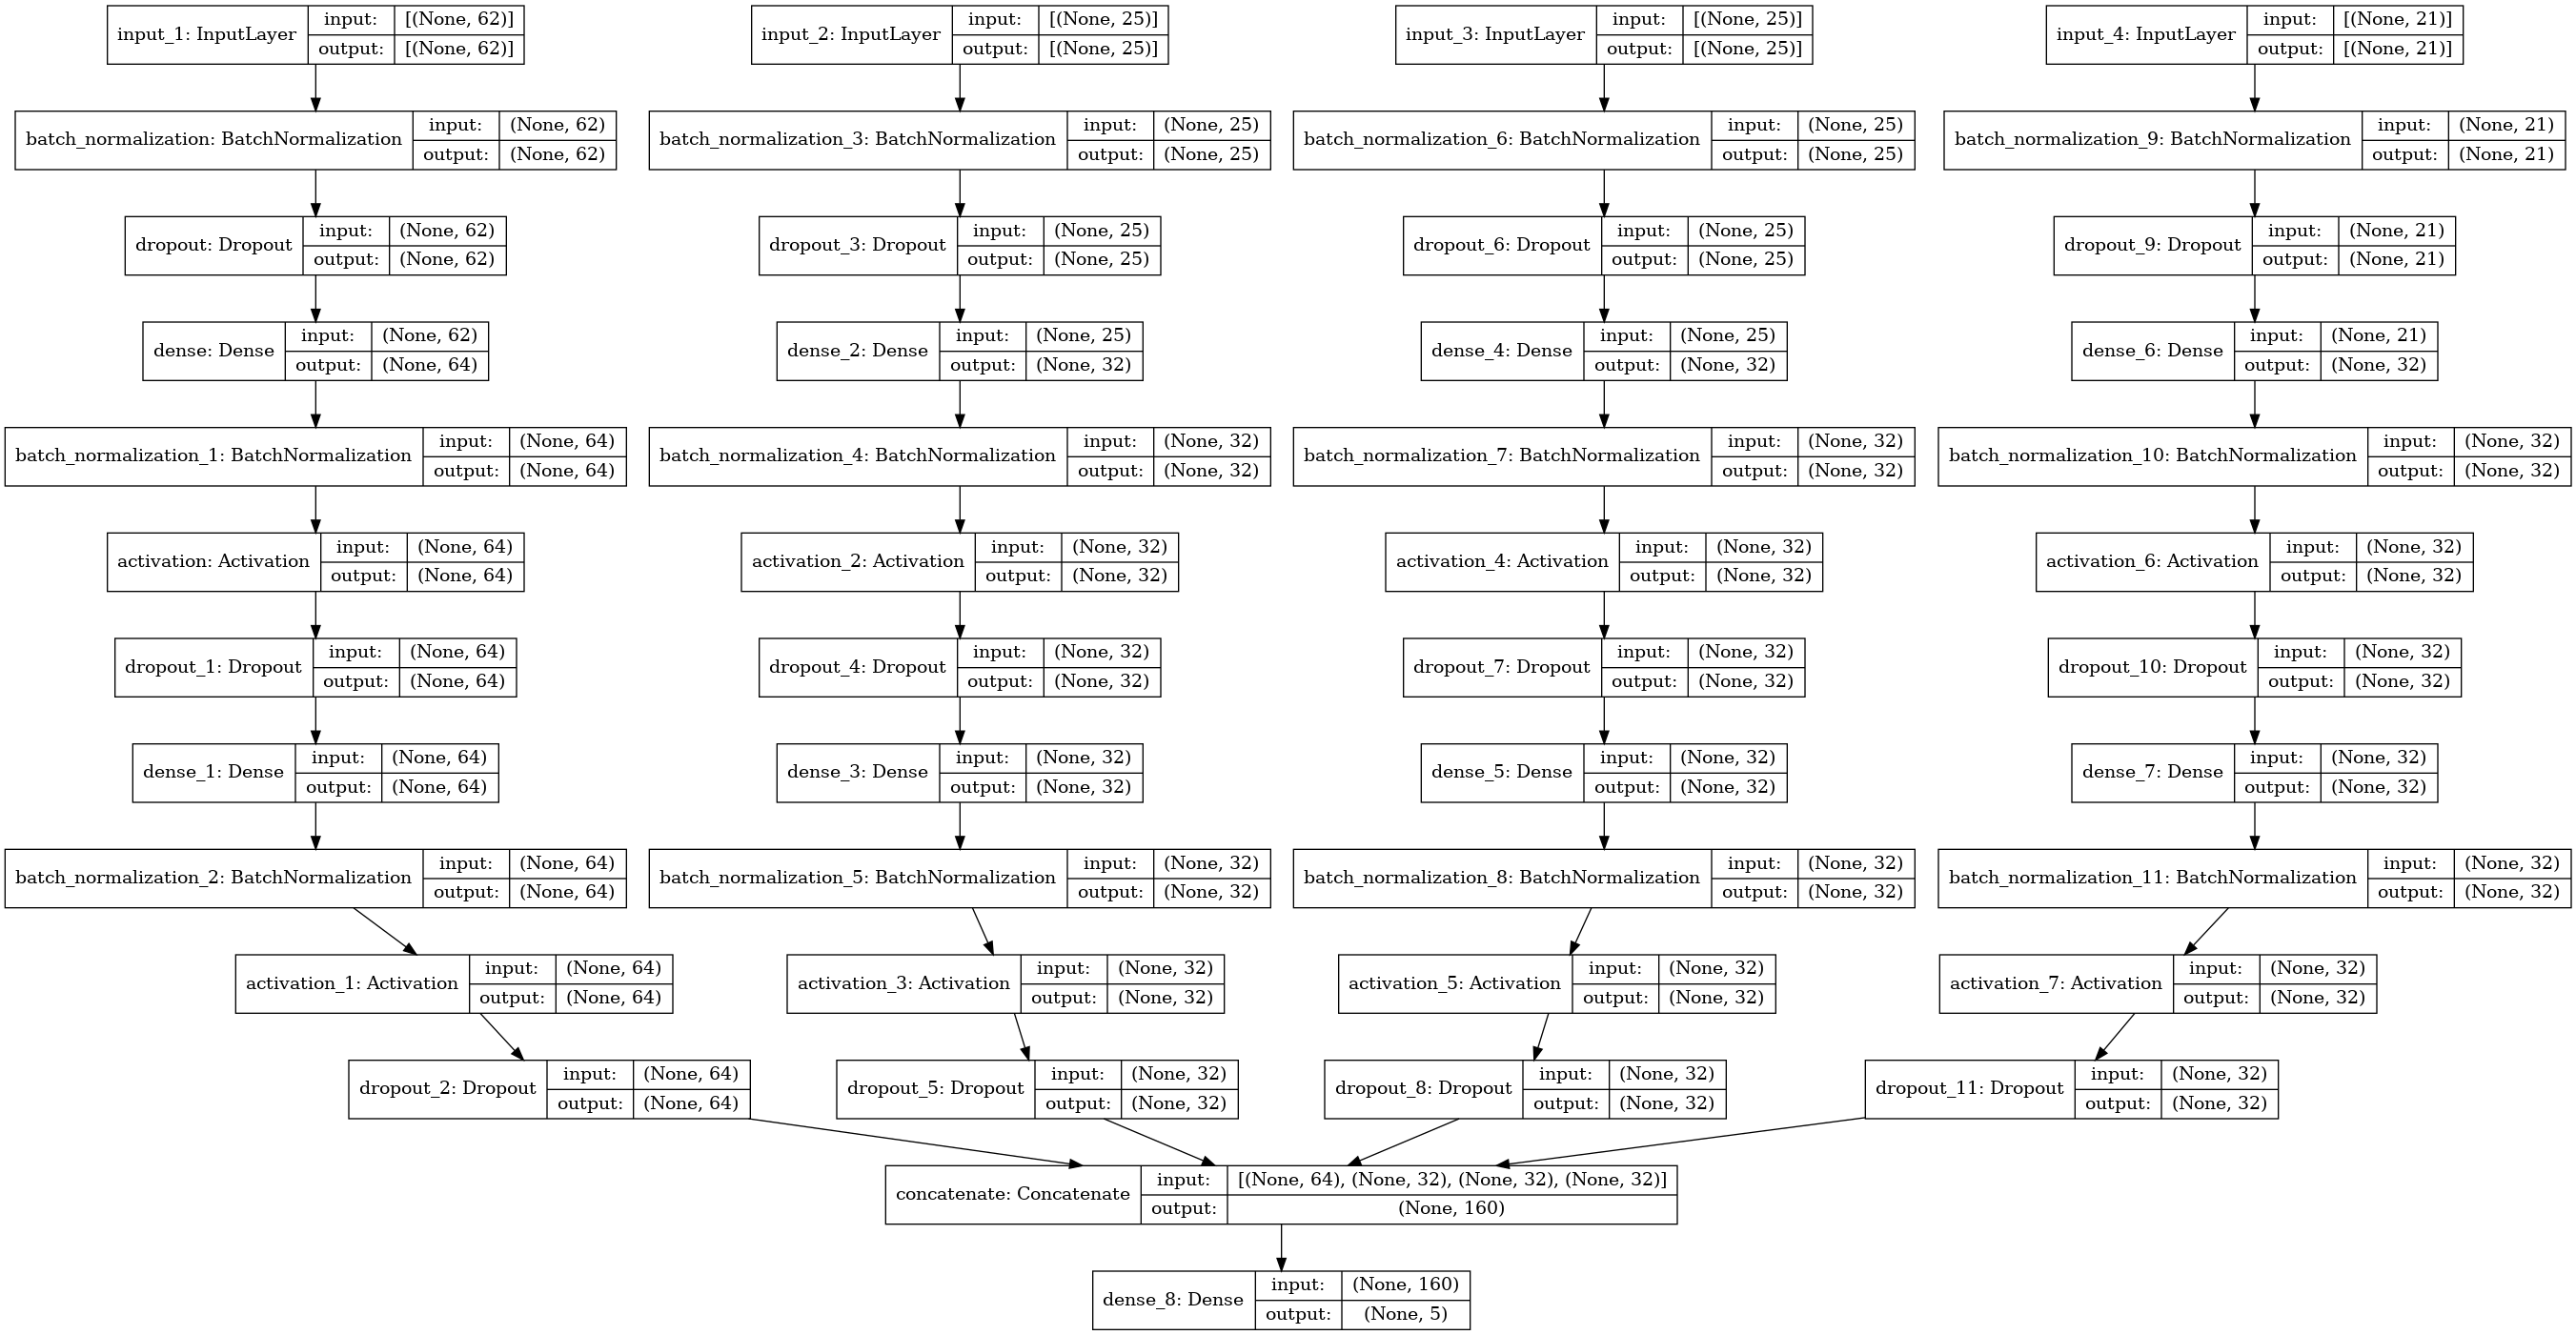

In [ ]:
name = "mlp"
batch_size = 4096*16
hidden_units = [64, 32, 64, 130, 256, 256, 128]
dropout_rates = [0.1, 0.2, 0.2, 0.2, 0.25, 0.25, 0.25, 0.25]
label_smoothing = 1e-2
learning_rate = 1e-3

scores_list = []
gtss = GroupTimeSeriesSplit(n_splits = 5)

# for fold, (train_idx, test_idx) in enumerate(gtss.split(y, groups=train['date'])):
#     start_time_fold = time()
    
# #     X_train, X_val = X.loc[train_idx, features].values, train.loc[test_idx, features].values
# #     y_train, y_val = y.loc[train_idx, 'action'].values, train.loc[test_idx, 'action'].values
#     X_train, X_val = X[train_idx], X[test_idx]
#     y_train, y_val = y[train_idx], y[test_idx]
    
#     X_t_1 = X_train[:, c_1_]
#     X_t_2 = X_train[:, c_2_]
#     X_t_3 = X_train[:, c_3_]
#     X_t_4 = X_train[:, c_4_]
    
#     X_v_1 = X_val[:, c_1_]
#     X_v_2 = X_val[:, c_2_]
#     X_v_3 = X_val[:, c_3_]
#     X_v_4 = X_val[:, c_4_]
    
#     X_train_ = [X_t_1, X_t_2, X_t_3, X_t_4]
#     X_val_ = [X_v_1, X_v_2, X_v_3, X_v_4]

#     ckp_path = f'JSModel_{fold}.hdf5'
#     model = create_mlp(f_shape, 5, hidden_units, dropout_rates, label_smoothing, learning_rate)
    
#     model.summary()

#     history = model.fit(
#         X_train_,
#         y_train,
#         batch_size = batch_size,
#         validation_data = (X_val_, y_val),
#         epochs = 250,
#         callbacks = get_callbacks(name, fold),
#         verbose = 1)
    
#     hist = pd.DataFrame(history.history)
#     print(f'[{str(datetime.timedelta(seconds = time() - start_time_fold))[0:7]}] Fold {fold} ROC AUC:\t', hist['val_AUC'].max())
#     scores_list.append(hist['val_AUC'].max())
#     # print(model.predict(X_val_, batch_size = batch_size).shape)
#     # print(np.mean(model.predict(X_val_, batch_size = batch_size), axis=1).shape)
#     val_res = np.where(np.mean(model.predict(X_val_, batch_size = batch_size), axis=1).ravel() > 0.5, 1, 0).astype(int)
#     val_res2 = np.where(np.median(model.predict(X_val_, batch_size = batch_size), axis=1).ravel() > 0.5, 1, 0).astype(int)

#     print("full u_score:", utility_score_bincount(train.date[test_idx], train.weight[test_idx], train.resp[test_idx], train.action[test_idx]))
#     print("model u_score:", utility_score_bincount(train.date[test_idx], train.weight[test_idx], train.resp[test_idx], val_res))
#     print("model u_score:", utility_score_bincount(train.date[test_idx], train.weight[test_idx], train.resp[test_idx], val_res2))
    
#     # Finetune 3 epochs on validation set with small learning rate
#     model = create_mlp(f_shape, 1, hidden_units, dropout_rates, label_smoothing, learning_rate / 100)
#     model.load_weights(ckp_path)
#     model.fit(X_val_, y_val, epochs = 3, batch_size = batch_size, verbose = 0)
#     model.save_weights(ckp_path)
    
#     K.clear_session()
#     del model
#     rubbish = gc.collect()

In [ ]:
models_idx = [0,1,2,3,4]

models = []
for i in models_idx:
    clf = create_mlp(f_shape, 5, hidden_units, dropout_rates, label_smoothing, learning_rate)
    path = f'../input/stacknnmodels/JSModel_{i}.hdf5'
    print(path)
    clf.load_weights(path)
#     clf.load_weights(f'./JSModel_{i}.hdf5')
    models.append(clf)

In [ ]:
import janestreet
env = janestreet.make_env()
env_iter = env.iter_test()

In [ ]:
opt_th = 0.5
w = np.asarray([0.05,0.05,0.1,0.5,0.3])
for (test_df, pred_df) in tqdm(env_iter):
    if test_df['weight'].item() > 0:
        x_tt = test_df.loc[:, features].values
        if np.isnan(x_tt[:, 1:].sum()):
            x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
        
        x_tt_1 = x_tt[:, c_1_]
        x_tt_2 = x_tt[:, c_2_]
        x_tt_3 = x_tt[:, c_3_]
        x_tt_4 = x_tt[:, c_4_]
    
        x_tt_ = [x_tt_1, x_tt_2, x_tt_3, x_tt_4]
        
        # pred = np.mean([model.predict(x_tt_) for model in models[-2:]],axis=0).squeeze()
        # pred = np.average(models[-2](x_tt_, training = False).numpy().squeeze(), weights=w)
        pred = np.mean(models[-2](x_tt_, training = False).numpy().squeeze())
        pred_df.action = np.where(pred >= opt_th, 1, 0).astype(int)
    else:
        pred_df.action = 0
    env.predict(pred_df)